In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import sys

In [4]:
import isbnlib

In [12]:
isbnlib.classify('0912333022')

ISBNLibHTTPError: an HTTP error has ocurred (403 Are you making many requests?)

In [21]:
#isbnlib.is_isbn13('B000234N3A')
# ddc lcc
print(isbnlib.classify(isbnlib.get_isbnlike('0912333022')))

ISBNLibHTTPError: an HTTP error has ocurred (403 Are you making many requests?)

In [3]:
book_df = pd.read_csv("/home/code/data/books.csv")
user_df = pd.read_csv("/home/code/data/users.csv")

In [4]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


# 1. Book_df

In [3]:
book_df.tail(2)

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,['Fiction'],These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg
149569,1569661057,"Dallas Street Map Guide and Directory, 2000 Ed...",Mapsco,1999.0,American Map Corporation,http://images.amazon.com/images/P/1569661057.0...,NaN,NaN,NaN,images/1569661057.01.THUMBZZZ.jpg


In [4]:
# language, category, summary에 결측치 다수 존재
# book_author에 결측치 1개
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


## 1-1. isbn

- 2자리 : 출판 국가 또는 언어 번호
- 4자리 : 출판사 번호
- 3자리 : 발행 순서
- 1자리 : 확인 숫자 (여기에는 10을 나타내는 X가 올 수도 있다)

In [5]:
# 결측치 확인
# 결측치 없음
book_df.loc[book_df["isbn"].isnull() == True]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


- 현재는 미국을 제외하면 거의 쓰이지 않는 10의 자리 isbn을 사용
    1. 10 자리 ISBN을 (A,B,C,D,E,F,G,H,I,J) 라 하고, 마지막 J를 제외한 (A,B,C,D,E,F,G,H,I) 벡터를 만든다. 이 벡터를 b라 한다.
    2. a = (1,2,3,4,5,6,7,8,9) 라 한다.
    3. ( a · b ) % 11의 값을 J로 정하되, 이 값이 10일 경우는 X로 표기한다.
    4. 점곱은 유클리드 내적이다. A*1+B*2+C*3+.....9*I 전산 언어가 아닌 일반적인 식으로 쓰면
        - A + 2B + 3C + ⋯ + 9 I mod 11 = J

In [6]:
# isbn 길이 분포
# 모두 동일한 길이 
print(len(book_df["isbn"].min()), len(book_df["isbn"].max()))

10 10


In [7]:
book_df["isbn"].sort_values()

122165    0000913154
38537     0001046438
38538     000104687X
38539     0001047213
24924     0001047973
             ...    
137364    B0001FZGPI
130283    B0001FZGRQ
39715     B0001GMSV2
114951    B0001I1KOG
97189     B000234N3A
Name: isbn, Length: 149570, dtype: object

In [9]:
# isbn을 각 자리별로 split
isbn_df = pd.DataFrame(book_df["isbn"])
isbn_df['isbn_country'] = isbn_df["isbn"].apply(lambda x : x[:1])
isbn_df['isbn_publisher'] = isbn_df["isbn"].apply(lambda x : x[2:6])
isbn_df['isbn_publish_num'] = isbn_df["isbn"].apply(lambda x : x[6:9])
isbn_df['isbn_check_num'] = isbn_df["isbn"].apply(lambda x : x[-1])

In [11]:
# 출판 국가 코드와 언어와의 관게
isbn_df["language"] = book_df["language"]

In [27]:
isbn_df.head()

,isbn,isbn_country,isbn_publisher,isbn_publish_num,isbn_check_num
0,0002005018,00,0200,501,8
1,0060973129,00,6097,312,9
2,0374157065,03,7415,706,5
3,0399135782,03,9913,578,2
4,0425176428,04,2517,642,8


In [28]:
# 출판 국가 분포
print(isbn_df["isbn_country"].value_counts())
print(len(isbn_df["isbn_country"].value_counts()))

isbn_country
03    27473
08    17812
04    15671
06    13441
05    11852
      ...  
75        1
53        1
41        1
44        1
46        1
Name: count, Length: 69, dtype: int64
69


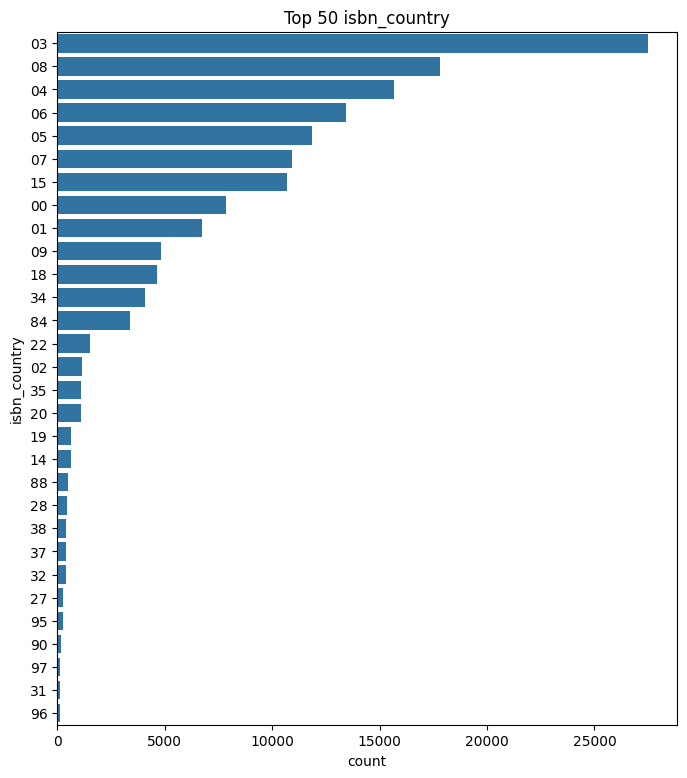

In [11]:
# 출판 국가 시각화
ds = isbn_df['isbn_country'].value_counts().reset_index()
ds.columns = ['isbn_country', 'count']
ds = ds.sort_values('count', ascending=False).head(30)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='isbn_country', data=ds, orient='h')
plt.title('Top 50 isbn_country')
plt.show()

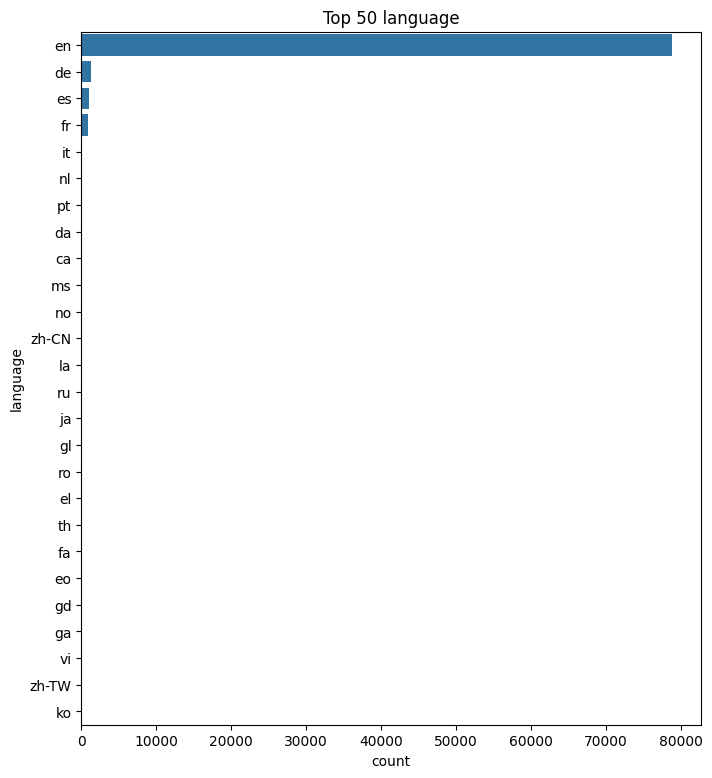

In [30]:
# 출판 국가 시각화
ds = isbn_df['language'].value_counts().reset_index()
ds.columns = ['language', 'count']
ds = ds.sort_values('count', ascending=False).head(30)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='language', data=ds, orient='h')
plt.title('Top 50 language')
plt.show()

In [31]:
isbn_df['isbn_country'].unique()

array(['00', '03', '04', '06', '07', '08', '15', '18', '09', '05', '34',
       '01', '02', '20', '14', '84', '97', '19', '31', '32', '35', '96',
       '88', '22', '28', '29', '37', '38', '95', '27', '47', 'B0', '85',
       '99', '39', '36', '98', '33', '55', '86', '90', '83', '17', '30',
       '80', '81', '91', '50', '82', '21', '25', '87', '89', '92', '54',
       '71', '53', '48', '78', '58', '49', '26', '75', '45', '43', '40',
       '41', '44', '46'], dtype=object)

In [32]:
isbn_df.head()

,isbn,isbn_country,isbn_publisher,isbn_publish_num,isbn_check_num,language
0,0002005018,00,0200,501,8,en
1,0060973129,00,6097,312,9,en
2,0374157065,03,7415,706,5,en
3,0399135782,03,9913,578,2,en
4,0425176428,04,2517,642,8,en


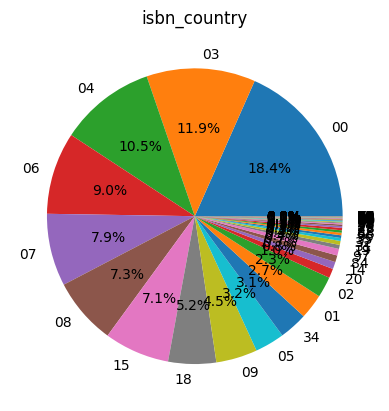

In [ ]:
ratio = isbn_df['isbn_country'].value_counts()
labels = isbn_df['isbn_country'].unique()
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.title("isbn_country")
plt.show()

In [ ]:
book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


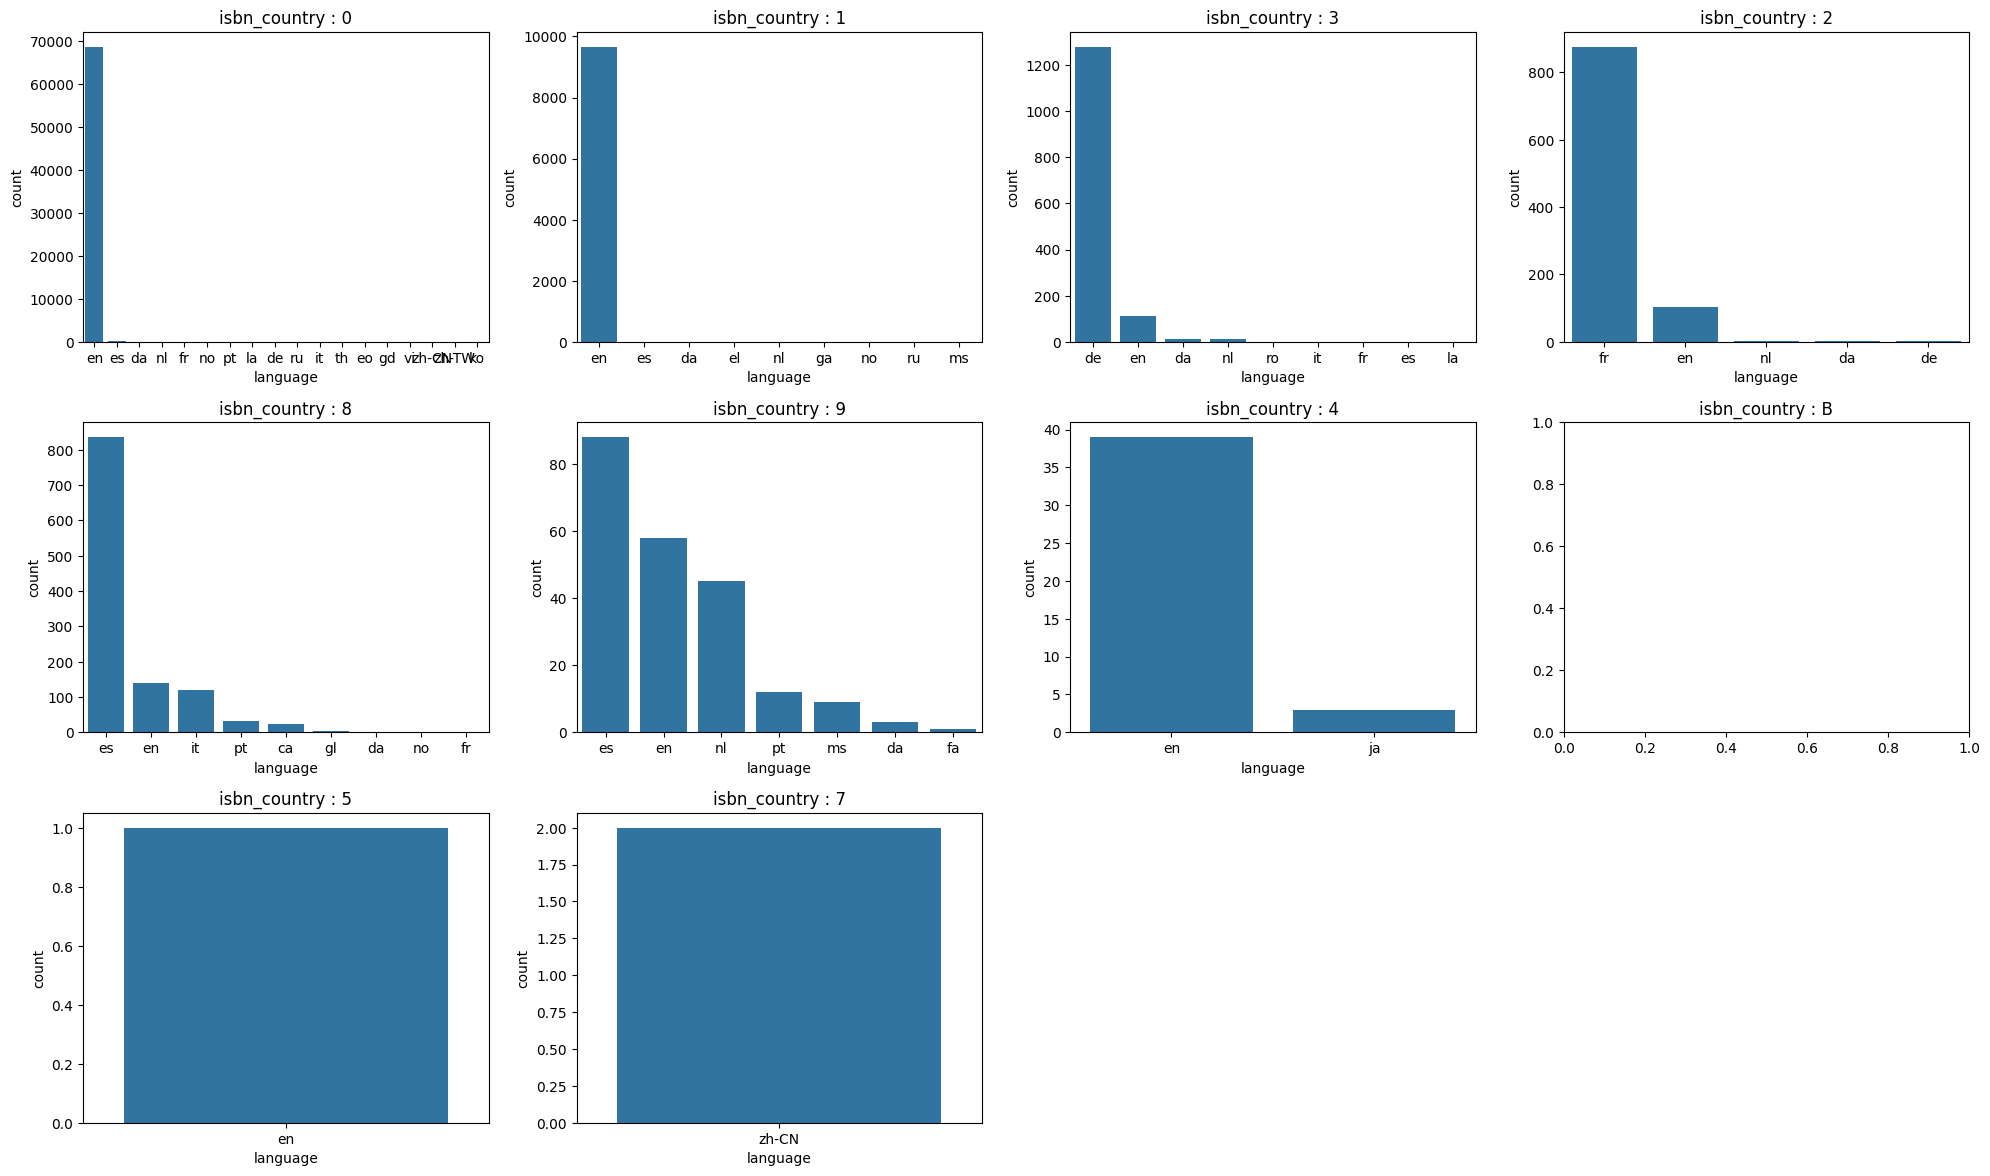

In [12]:
# 해당 국가 코드에서 가장 많이 사용한 언어로 language null 대체 
# 국가 코드별 사용 언어
# 국가코드 한자리
plt.figure(figsize=(20, 70))
for idx, i in enumerate(isbn_df['isbn_country'].unique()):
    
    plt.subplot(18, 4, idx+1)
    ds = isbn_df["language"].loc[isbn_df["isbn_country"] == i].value_counts().reset_index()
    ds.columns = ["language", 'count']
    ds = ds.sort_values('count', ascending=False)
    plt.title("isbn_country : {}".format(i))
    sns.barplot(x='language', y="count", data=ds)
plt.tight_layout()
plt.show()

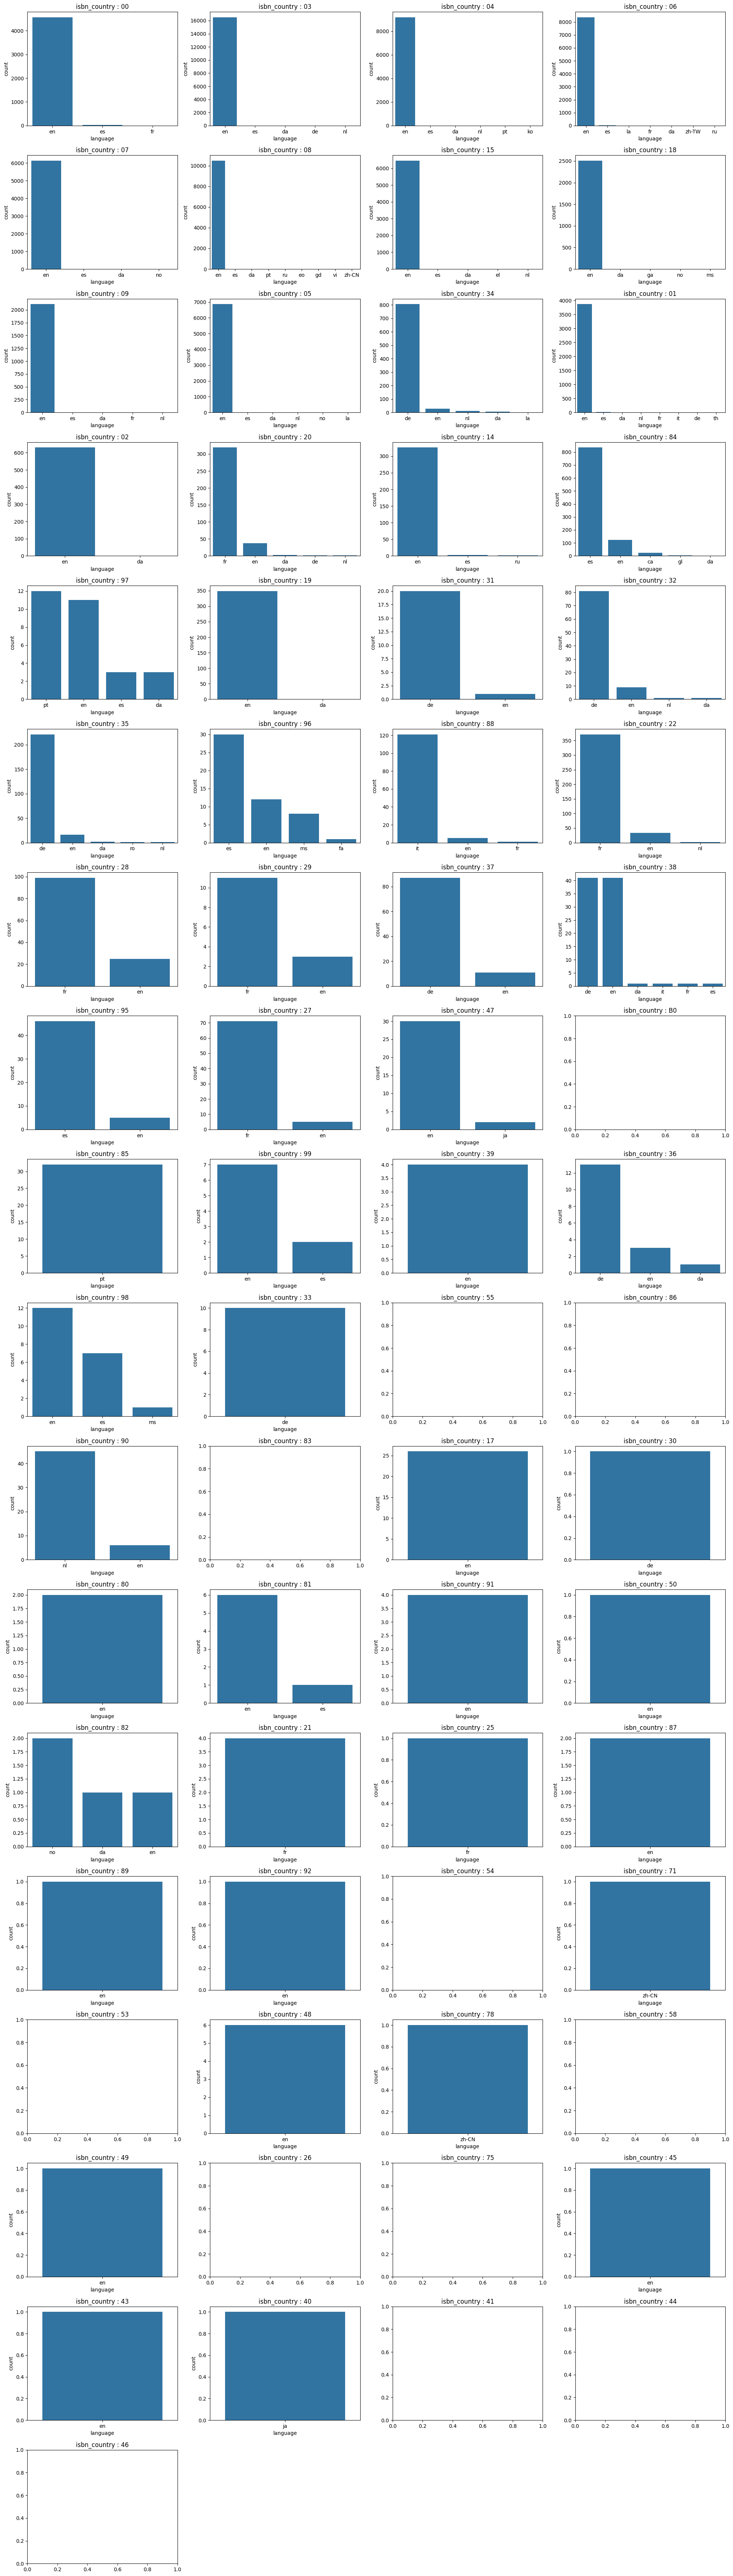

In [33]:
# 해당 국가 코드에서 가장 많이 사용한 언어로 language null 대체 
# 국가 코드별 사용 언어
plt.figure(figsize=(20, 70))
for idx, i in enumerate(isbn_df['isbn_country'].unique()):
    
    plt.subplot(18, 4, idx+1)
    ds = isbn_df["language"].loc[isbn_df["isbn_country"] == i].value_counts().reset_index()
    ds.columns = ["language", 'count']
    ds = ds.sort_values('count', ascending=False)
    plt.title("isbn_country : {}".format(i))
    sns.barplot(x='language', y="count", data=ds)
plt.tight_layout()
plt.show()

## 1-2. book_title

In [43]:
book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [46]:
book_df["book_title"].value_counts()

book_title
The Secret Garden                                                                                  18
Selected Poems                                                                                     16
Dracula                                                                                            15
Adventures of Huckleberry Finn                                                                     15
Wuthering Heights                                                                                  14
                                                                                                   ..
AGAINST OUR WILL                                                                                    1
The shadow of the winter palace: Russia's drift to revolution, 1825-1917                            1
Pippi Longstocking (Pippi Longstocking Books)                                                       1
The Book of Salt                                                       

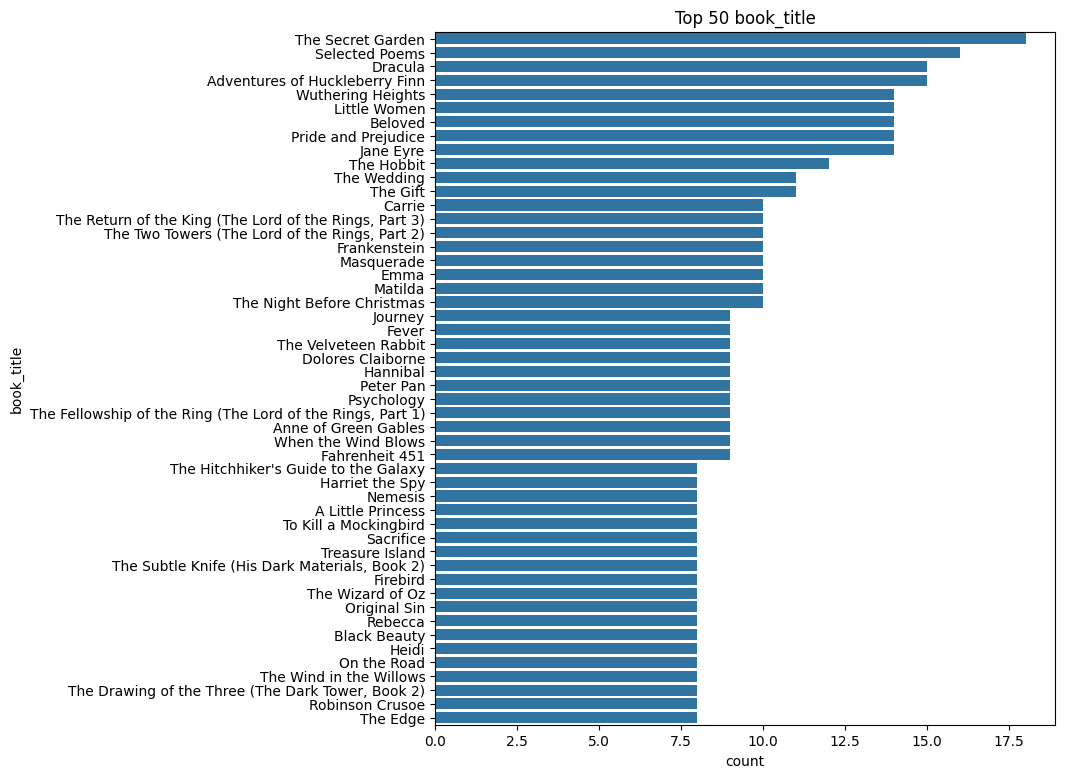

In [45]:
# 상위 50개 book_title 시각화
ds = book_df['book_title'].value_counts().reset_index()
ds.columns = ['book_title', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='book_title', data=ds, orient='h')
plt.title('Top 50 book_title')
plt.show()

In [47]:
def text_preprocessing(summary):
    """
    Parameters
    ----------
    summary : pd.Series
        정규화와 같은 기본적인 전처리를 하기위한 텍스트 데이터를 입력합니다.
    ----------
    """
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary


In [56]:
book_df["book_title_preprocessing"] = book_df["book_title"].apply(lambda x : text_preprocessing(x))

In [51]:
# book_title에서 소문자, 특수문자 제거했을 때 분포 확인

print(len(book_df["book_title"].unique()),len(book_df["book_title_preprocessing"].unique()))

135436 132659


In [57]:
# 135436에서 132659로 범주가 줄어듦 따라서 book_title을 전처리한 데이터로 변경
book_df["book_title"] = book_df["book_title_preprocessing"]
book_df = book_df.drop("book_title_preprocessing", axis = 1)
book_df.columns

Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')

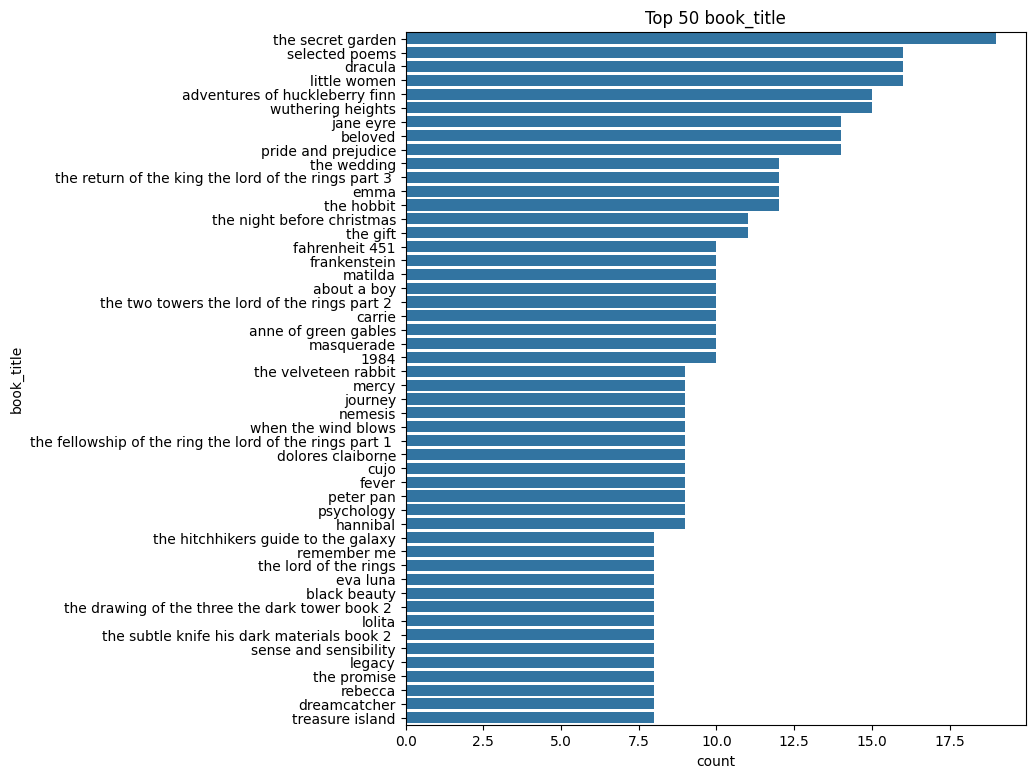

In [72]:
# 전처리를 적용한 상위 50개 book_title 시각화
# 순위가 변경됨을 확인
ds = book_df['book_title'].value_counts().reset_index()
ds.columns = ['book_title', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='book_title', data=ds, orient='h')
plt.title('Top 50 book_title')
plt.show()

In [73]:
book_title_top50 = ds.copy()

In [74]:
# 상위 50개 book_title의 언어 분포 확인
for title in book_title_top50["book_title"]:
    print(title)
    print(book_df["language"].loc[book_df["book_title"] == title].value_counts())

the secret garden
language
en    14
Name: count, dtype: int64
selected poems
language
en    9
Name: count, dtype: int64
dracula
language
en    5
Name: count, dtype: int64
little women
language
en    5
Name: count, dtype: int64
adventures of huckleberry finn
language
en    7
Name: count, dtype: int64
wuthering heights
language
en    6
Name: count, dtype: int64
jane eyre
language
en    5
es    1
Name: count, dtype: int64
beloved
language
en    8
Name: count, dtype: int64
pride and prejudice
language
en    8
Name: count, dtype: int64
the wedding
language
en    6
Name: count, dtype: int64
the return of the king the lord of the rings part 3 
language
en    6
Name: count, dtype: int64
emma
language
en    3
Name: count, dtype: int64
the hobbit
language
en    6
Name: count, dtype: int64
the night before christmas
language
en    6
Name: count, dtype: int64
the gift
language
en    5
Name: count, dtype: int64
fahrenheit 451
language
en    6
de    2
es    1
Name: count, dtype: int64
frankenstein
l

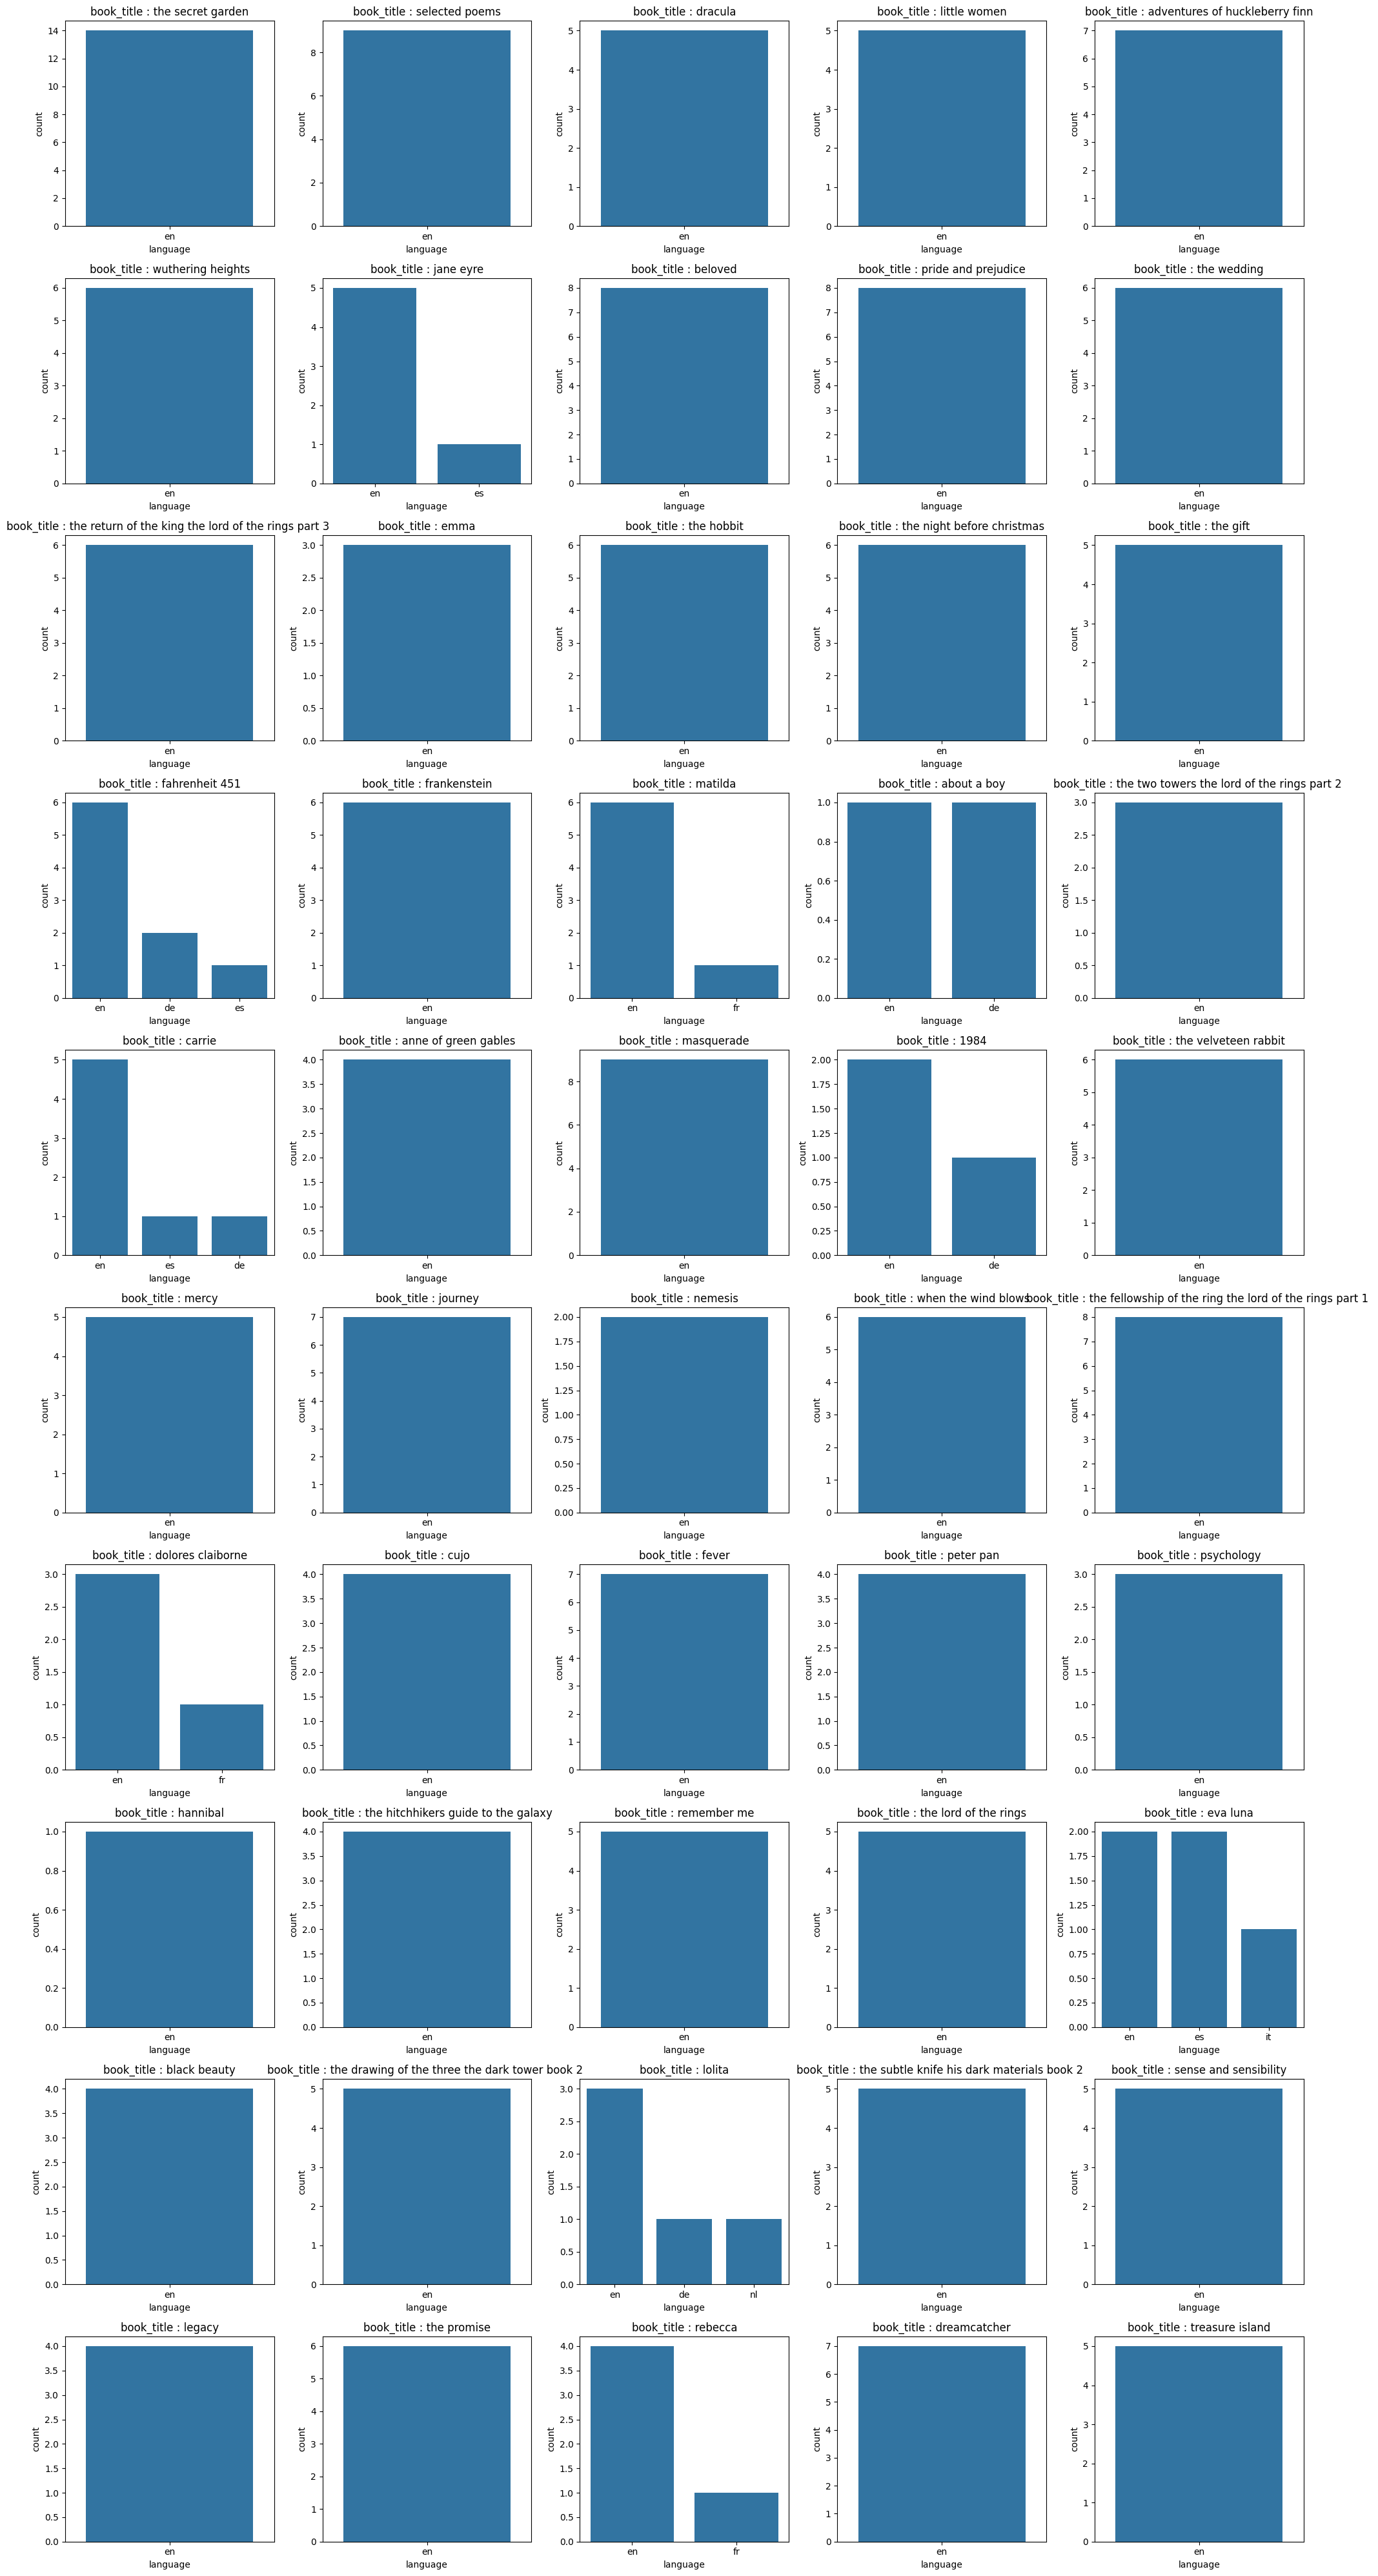

In [77]:
# 상위 50개 book_title의 언어 분포 확인
# 최대 3가지의 언어로 번역되었지만 대부분의 책들은 출판사와 관계없이 영어로 번역
plt.figure(figsize=(20, 40))
for idx, i in enumerate(book_title_top50["book_title"]):
    
    plt.subplot(10, 5, idx+1)
    ds = book_df["language"].loc[book_df["book_title"] == i].value_counts().reset_index()
    ds.columns = ["language", 'count']
    ds = ds.sort_values('count', ascending=False)
    plt.title("book_title : {}".format(i))
    sns.barplot(x='language', y="count", data=ds)
plt.tight_layout()
plt.show()

/tmp/ipykernel_270093/2548052021.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


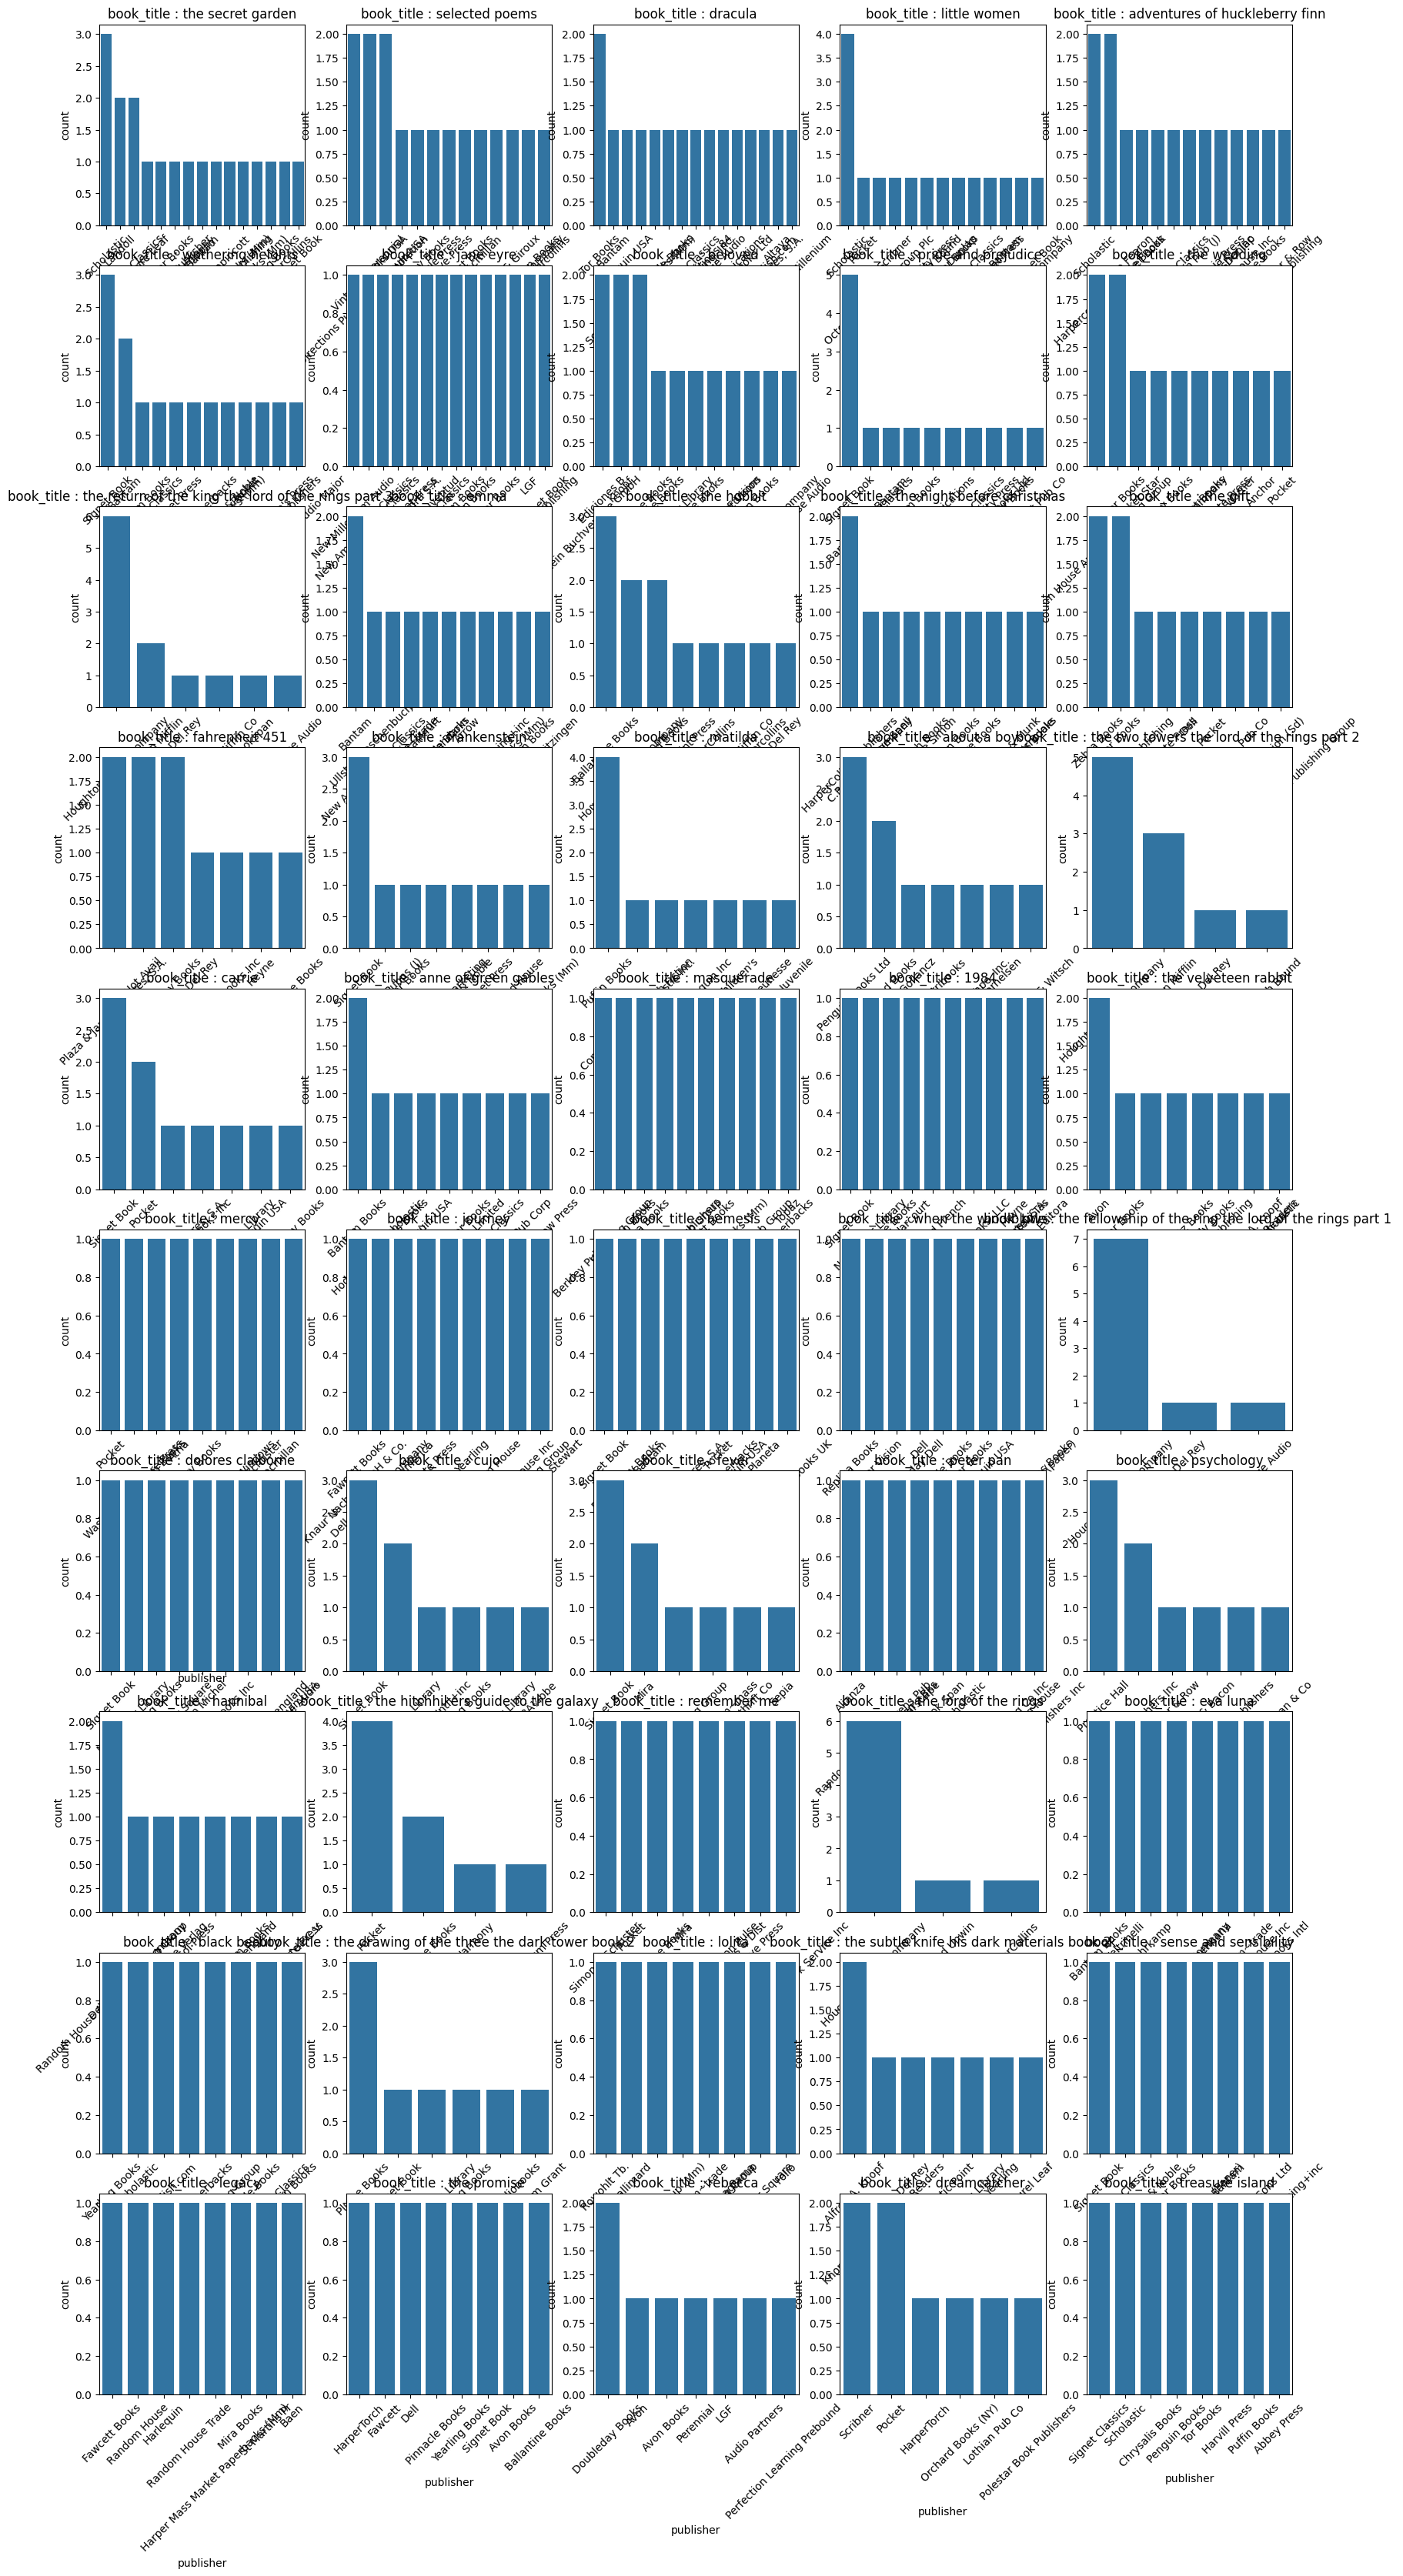

In [88]:
# 상위 50개 book_title의 출판사 분포 확인
# 다양한 출판사에서 책을 출간
plt.figure(figsize=(20, 40))
for idx, i in enumerate(book_title_top50["book_title"]):
    
    plt.subplot(10, 5, idx+1)
    ds = book_df["publisher"].loc[book_df["book_title"] == i].value_counts().reset_index()
    ds.columns = ["publisher", 'count']
    ds = ds.sort_values('count', ascending=False)
    plt.title("book_title : {}".format(i))
    
    sns.barplot(x='publisher', y="count", data=ds)
    plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## 1-3. book_author

In [92]:
book_df["book_author_preprocessing"] = book_df["book_author"].apply(lambda x : text_preprocessing(x))

In [93]:
# 전처리를 적용한 작가 count 변화
print(len(book_df["book_author"].unique()),len(book_df["book_author_preprocessing"].unique()))


62058 59492


In [94]:
# 62058에서 59492로 범주가 줄어듦 따라서 book_author을 전처리한 데이터로 변경
book_df["book_author"] = book_df["book_author_preprocessing"]
book_df = book_df.drop("book_author_preprocessing", axis = 1)
book_df.columns

Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')

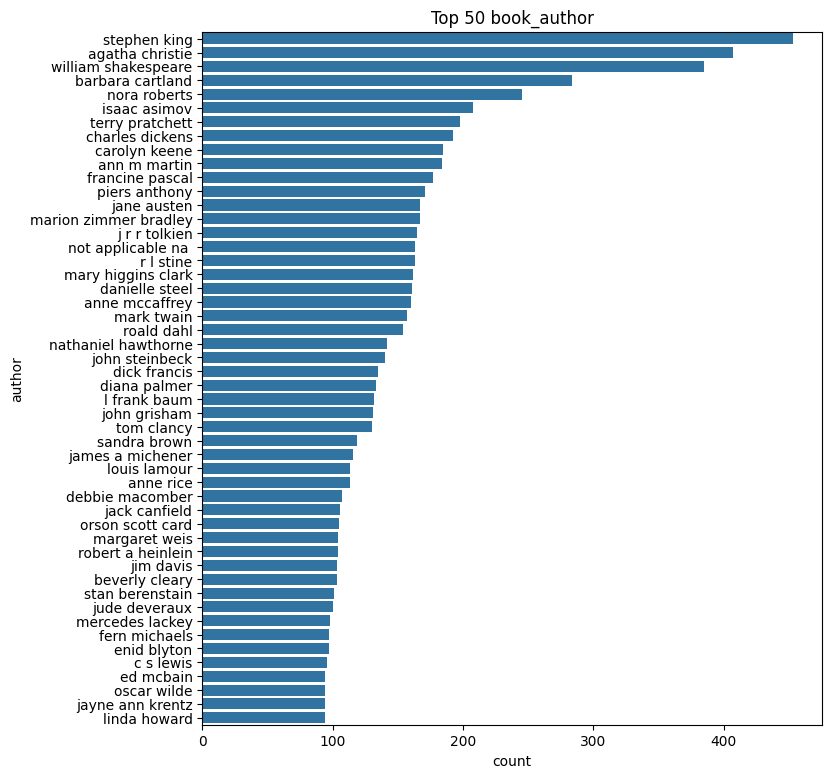

In [96]:
# 상위 50명 작가 확인
ds = book_df['book_author'].value_counts().reset_index()
ds.columns = ['author', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='author', data=ds, orient='h')
plt.title('Top 50 book_author')
plt.show()

## 1-4. publisher

In [114]:
# 전처리를 적용한 출판사 count 변화
book_df["book_publisher_preprocessing"] = book_df["publisher"].apply(lambda x : text_preprocessing(x))
print(len(book_df["publisher"].unique()),len(book_df["book_publisher_preprocessing"].unique()))


11571 11189


In [115]:
# 11571에서 11189로 범주가 줄어듦 따라서 book_author을 전처리한 데이터로 변경
book_df["publisher"] = book_df["book_publisher_preprocessing"]
book_df = book_df.drop("book_publisher_preprocessing", axis = 1)
book_df.columns

Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')

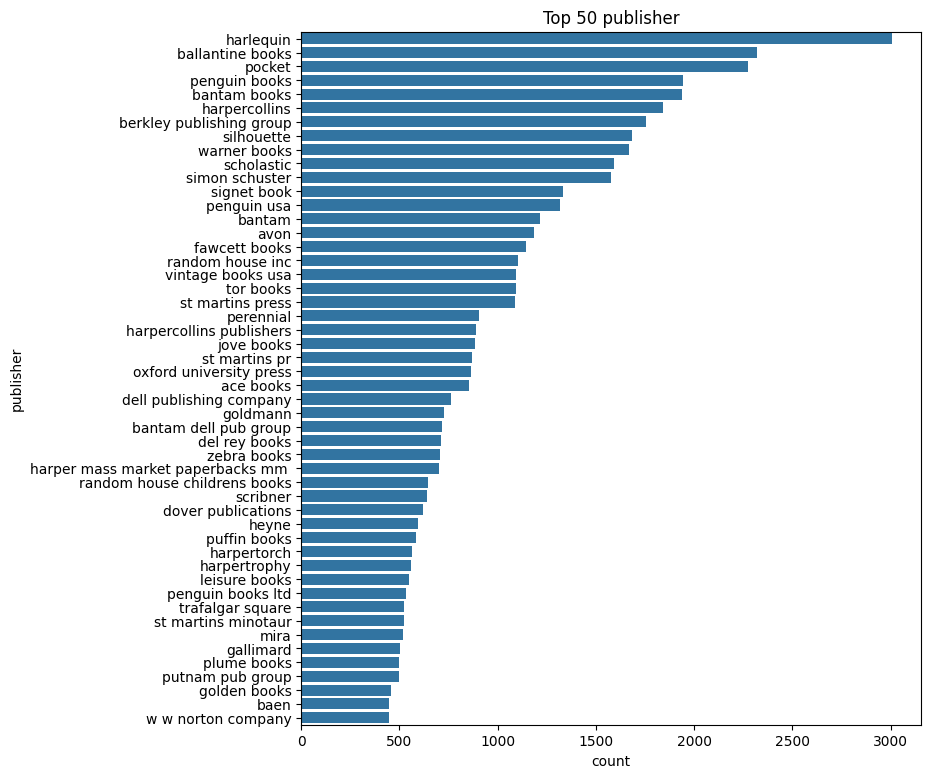

In [116]:
# 전처리를 적용한 상위 50개 publisher 시각화
# 순위가 변경됨을 확인
ds = book_df['publisher'].value_counts().reset_index()
ds.columns = ['publisher', 'count']
ds = ds.sort_values('count', ascending=False).head(50)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='publisher', data=ds, orient='h')
plt.title('Top 50 publisher')
plt.show()

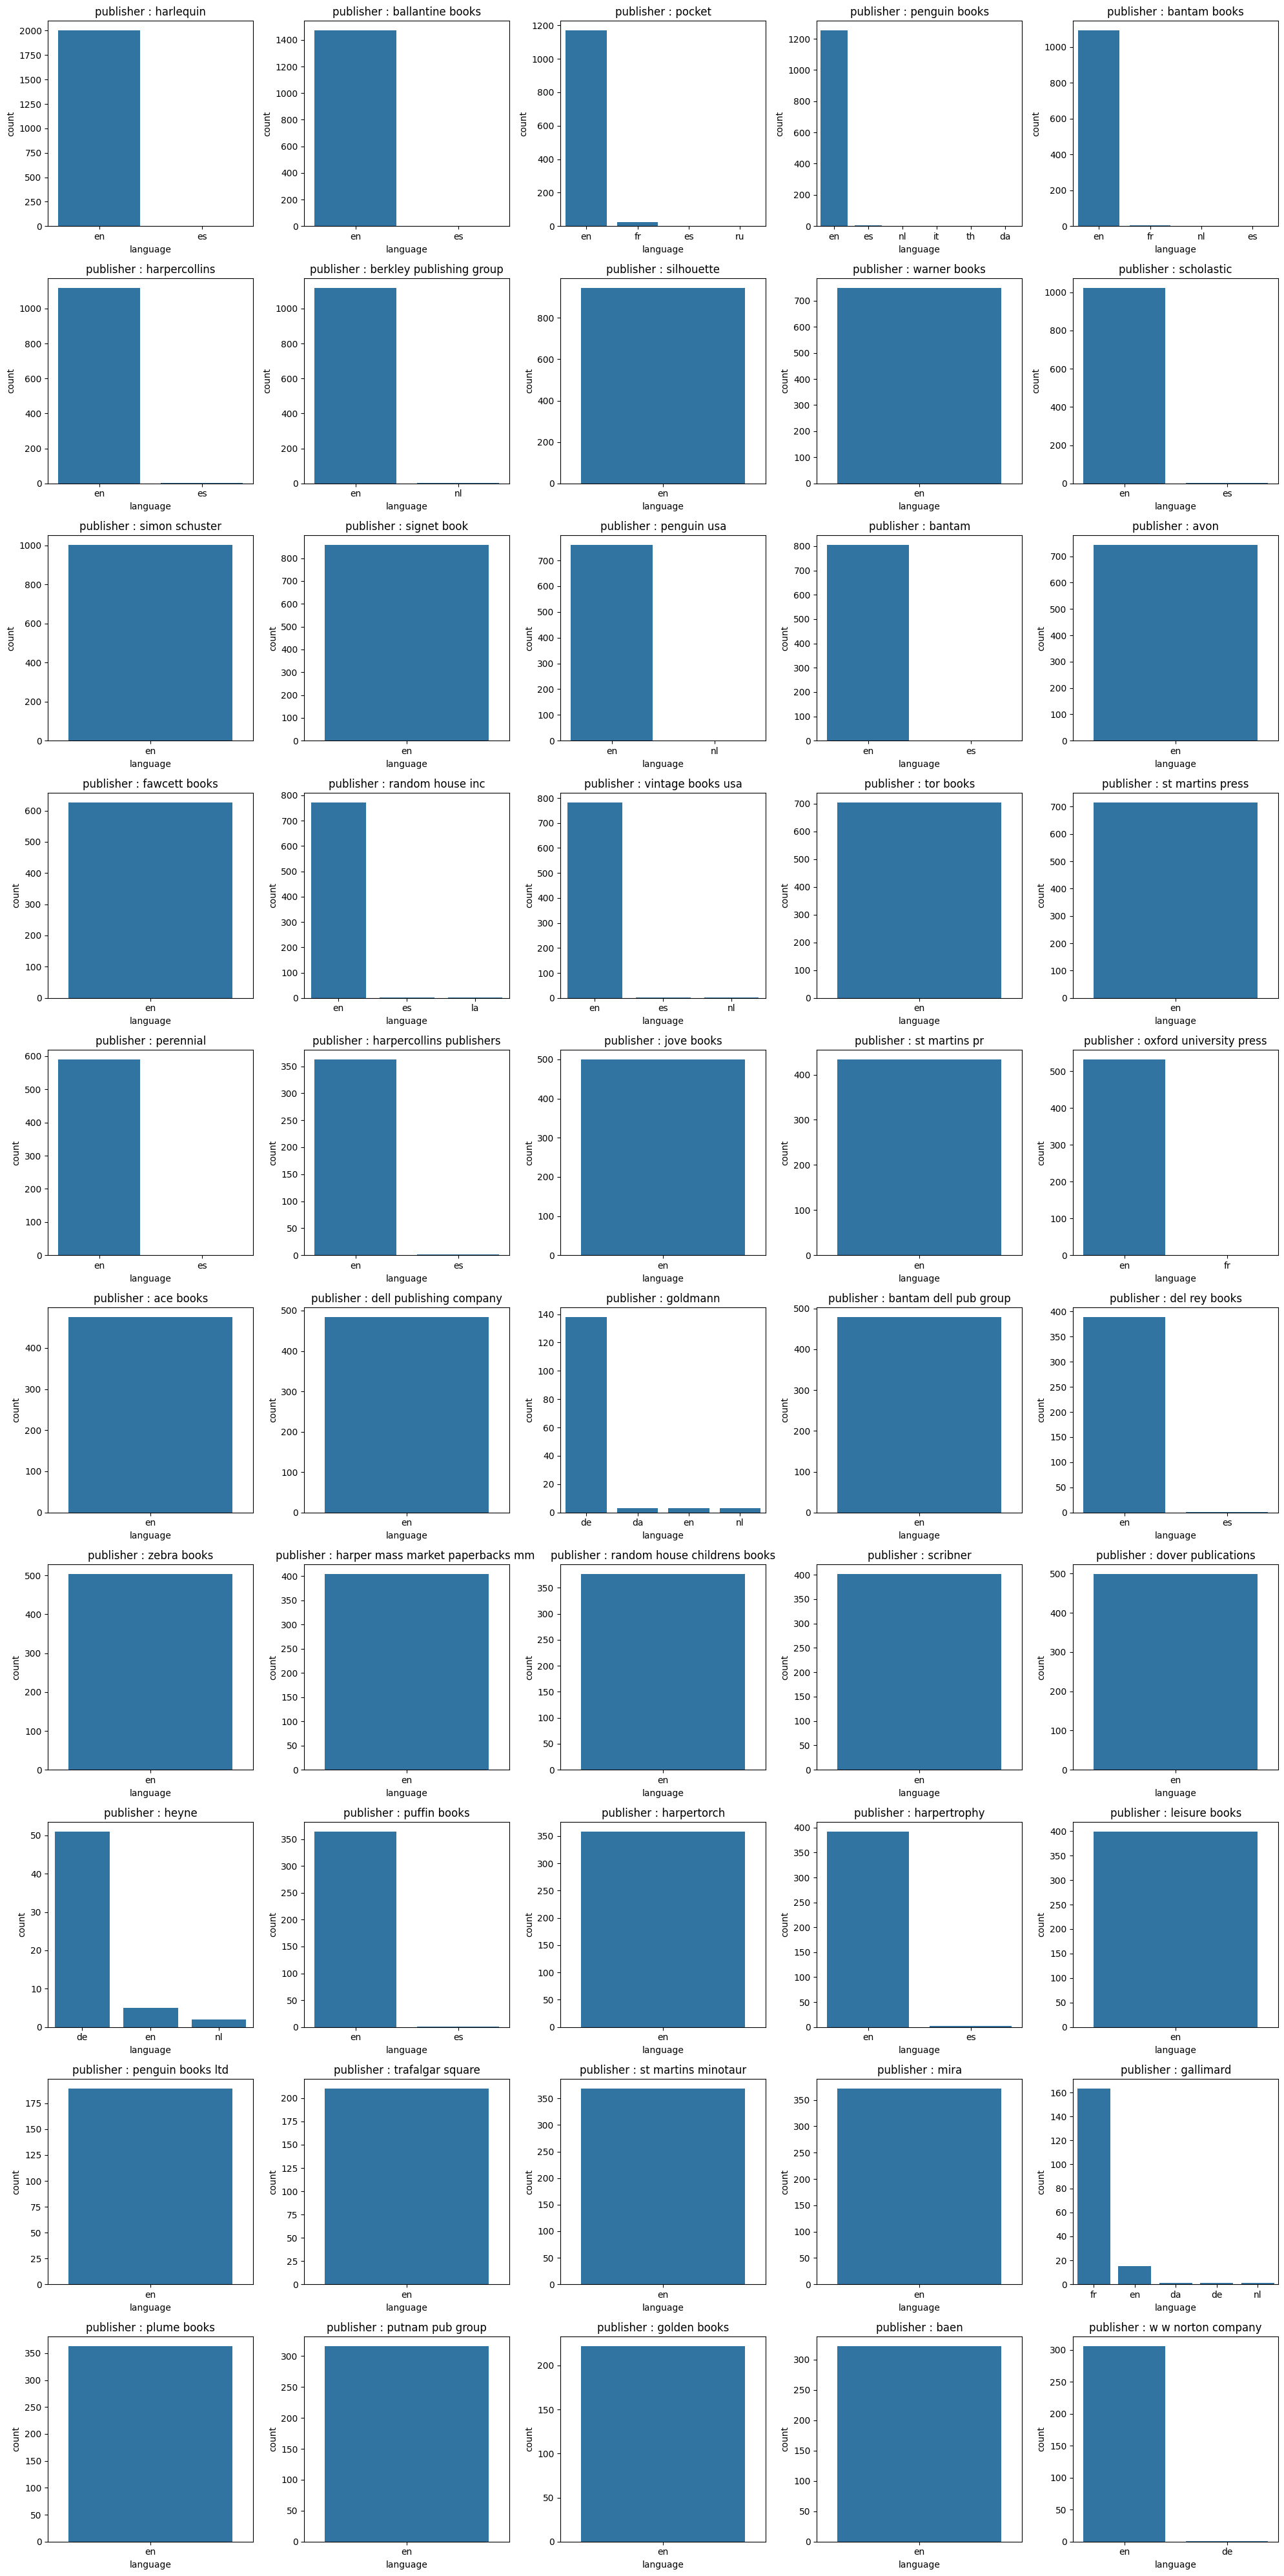

In [119]:
pub_top50 = ds.copy()
# 상위 50개 publisher별 언어 분포
plt.figure(figsize=(20, 40))
for idx, i in enumerate(pub_top50["publisher"]):
    
    plt.subplot(10, 5, idx+1)
    ds = book_df["language"].loc[book_df["publisher"] == i].value_counts().reset_index()
    ds.columns = ["language", 'count']
    ds = ds.sort_values('count', ascending=False)
    plt.title("publisher : {}".format(i))
    sns.barplot(x='language', y="count", data=ds)
plt.tight_layout()
plt.show()

## 1-5. book_image

In [97]:
# 이미지의 url로 들어가 보면 이미지가 없는 것을 확인 가능(비어있음)
print(book_df.loc[book_df["img_path"] == "images/0425139441.01.THUMBZZZ.jpg"]["img_url"])

76804    http://images.amazon.com/images/P/0425139441.0...
Name: img_url, dtype: object


In [129]:
book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,decision in normandy,carlo deste,1991.0,harperperennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,flu the story of the great influenza pandemic ...,gina bari kolata,1999.0,farrar straus giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,the kitchen gods wife,amy tan,1991.0,putnam pub group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,what if the worlds foremost military historian...,robert cowley,2000.0,berkley publishing group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [137]:
print(book_df.loc[book_df["img_path"] == "images/0767907566.01.THUMBZZZ.jpg"]["img_url"])
f_path = "/home/code/data/images/0767907566.01.THUMBZZZ.jpg"
img = Image.open(f_path)
img_array = np.array(img)
print(len(img_array))

149566    http://images.amazon.com/images/P/0767907566.0...
Name: img_url, dtype: object
75


In [110]:
from PIL import Image
import tqdm

In [131]:
# 이미지의 크기가 1일 경우 해당 인덱스를 저장
# 이미지는 있지만 비어있음
null_img = []
for path in tqdm.tqdm(book_df["img_path"]):
    f_path = "/home/code/data/" + path
    img = Image.open(f_path)
    img_array = np.array(img)
    if len(img_array) == 1:
        null_img.append(book_df.index[book_df["img_path"] == path])

  0%|          | 1/149570 [00:00<31:46, 78.44it/s]

0         images/0002005018.01.THUMBZZZ.jpg
1         images/0060973129.01.THUMBZZZ.jpg
2         images/0374157065.01.THUMBZZZ.jpg
3         images/0399135782.01.THUMBZZZ.jpg
4         images/0425176428.01.THUMBZZZ.jpg
                        ...                
149565    images/067161746X.01.THUMBZZZ.jpg
149566    images/0767907566.01.THUMBZZZ.jpg
149567    images/0884159221.01.THUMBZZZ.jpg
149568    images/0912333022.01.THUMBZZZ.jpg
149569    images/1569661057.01.THUMBZZZ.jpg
Name: img_path, Length: 149570, dtype: object


In [113]:
# 149570개의 이미지 중에서 41802개의 이미지가 비어있음
print(len(null_img), len(null_img)/len(book_df["img_path"]))

41802 0.2794811793808919


## 1-5. language

In [124]:
# 사용된 언어의 종류
print(len(book_df["language"].unique()))

27


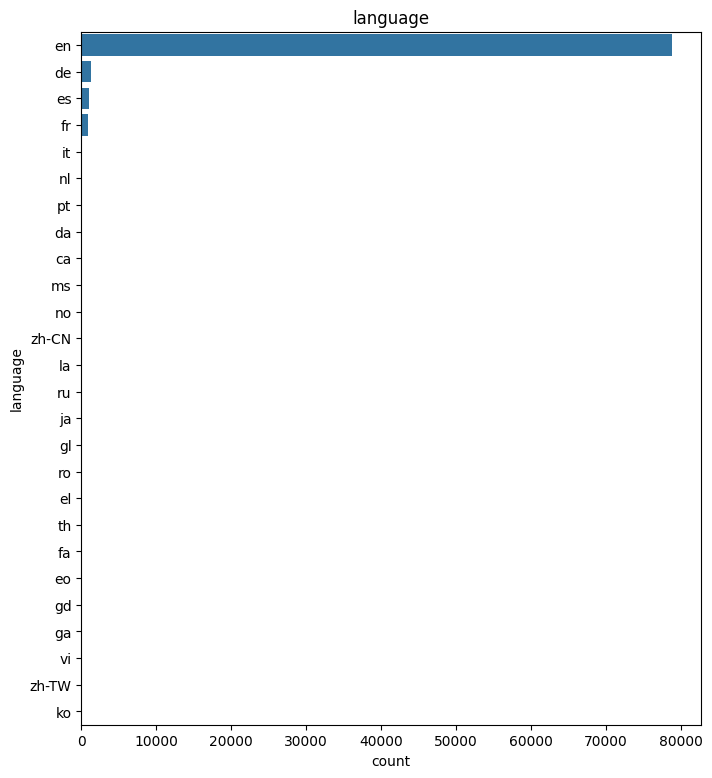

In [126]:
# 언어 분포 시각화
ds = book_df['language'].value_counts().reset_index()
ds.columns = ['language', 'count']
ds = ds.sort_values('count', ascending=False)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='language', data=ds, orient='h')
plt.title('language')
plt.show()

In [128]:
book_df["language"].unique()

array(['en', nan, 'de', 'fr', 'es', 'ca', 'it', 'da', 'nl', 'pt', 'ro',
       'no', 'ms', 'la', 'ru', 'el', 'zh-CN', 'th', 'gl', 'ja', 'fa',
       'eo', 'gd', 'ga', 'vi', 'zh-TW', 'ko'], dtype=object)

In [123]:
list(book_df)

['isbn',
 'book_title',
 'book_author',
 'year_of_publication',
 'publisher',
 'img_url',
 'language',
 'category',
 'summary',
 'img_path']

In [14]:
# 출판 국가 분포
print(isbn_df["isbn_country"].value_counts())
print(isbn_df["language"].value_counts())

isbn_country
03    27473
08    17812
04    15671
06    13441
05    11852
      ...  
75        1
53        1
41        1
44        1
46        1
Name: count, Length: 69, dtype: int64
language
en       78823
de        1282
es        1017
fr         883
it         123
nl          67
pt          47
da          37
ca          23
ms          10
no           6
zh-CN        3
la           3
ru           3
ja           3
gl           3
ro           1
el           1
th           1
fa           1
eo           1
gd           1
ga           1
vi           1
zh-TW        1
ko           1
Name: count, dtype: int64


In [15]:
isbn_df.loc[isbn_df["isbn_country"] == '04']["language"].value_counts()

language
en    9182
es       3
da       1
nl       1
pt       1
ko       1
Name: count, dtype: int64

In [16]:
# book_author 결측치 data
book_df.loc[book_df["book_author"].isnull() == True]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [18]:
book_df.iloc[4]

isbn                                                          0425176428
book_title             What If?: The World's Foremost Military Histor...
book_author                                                Robert Cowley
year_of_publication                                               2000.0
publisher                                       Berkley Publishing Group
img_url                http://images.amazon.com/images/P/0425176428.0...
language                                                              en
category                                                     ['History']
summary                Essays by respected military historians, inclu...
img_path                               images/0425176428.01.THUMBZZZ.jpg
Name: 4, dtype: object

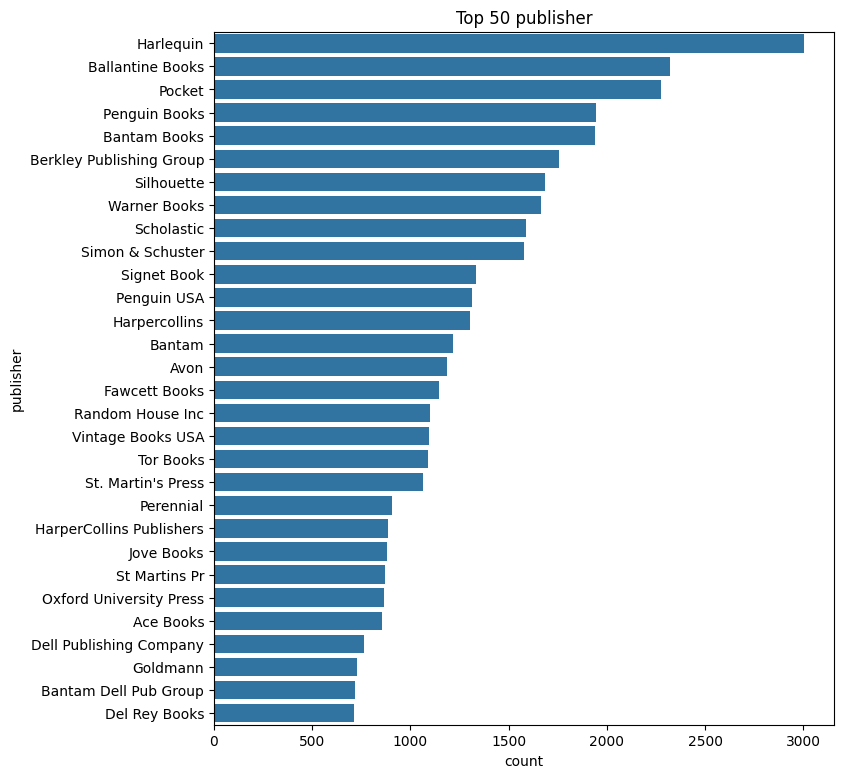

In [20]:
ds = book_df['publisher'].value_counts().reset_index()
ds.columns = ['publisher', 'count']
ds = ds.sort_values('count', ascending=False).head(30)

plt.figure(figsize=(8, 9))
sns.barplot(x='count', y='publisher', data=ds, orient='h')
plt.title('Top 50 publisher')
plt.show()

In [21]:
test_rating = pd.read_csv("/home/code/data/test_ratings.csv")
train_rating = pd.read_csv("/home/code/data/train_ratings.csv")

In [134]:
user_df["age"].value_counts().sort_index()

age
5.0     10
6.0      4
7.0     10
8.0     24
9.0     26
        ..
94.0     1
96.0     2
97.0     1
98.0     1
99.0     2
Name: count, Length: 91, dtype: int64

In [22]:
# book_author가 결측치인 data를 사용하는 data가 train에서 1개 밖에 없으므로 drop하려고 했으니 구글링해보니 진짜 저자가 없는 책이어서 unknown으로 변경
display(test_rating.loc[test_rating["isbn"] == '0751352497'])
display(train_rating.loc[train_rating["isbn"] == '0751352497'])

,user_id,isbn,rating


,user_id,isbn,rating
233060,63714,0751352497,10


In [23]:
book_df["book_author"] = book_df["book_author"].fillna("unknown")
book_df.loc[book_df["book_author"].isnull() == True]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [118]:
# book category 결측치 -> book image를 통해 장르를 유추
# https://github.com/rahulc-96/Book-Cover-Genre-Classifier -> book cover to genre
# https://github.com/akshaybhatia10/Book-Genre-Classification -> title to genre
book_df['category'].value_counts()

category
['Fiction']                        32956
['Juvenile Fiction']                5804
['Biography & Autobiography']       3320
['History']                         1925
['Religion']                        1818
                                   ...  
['Disguise']                           1
['Country lawyers']                    1
['Humorous stories, Brazilian']        1
['Coasts']                             1
['Vocational guidance']                1
Name: count, Length: 4292, dtype: int64

In [128]:
print(book_df['category'].isnull().sum()/len(book_df))
print("test dataset : ",int(len(book_df)* 0.4603262686367587))
print("train dataset : ", int(len(book_df)* (1-0.4603262686367587)))

0.4603262686367587
test dataset :  68851
train dataset :  80719


In [112]:
def text_preprocessing(summary):
    """
    Parameters
    ----------
    summary : pd.Series
        정규화와 같은 기본적인 전처리를 하기위한 텍스트 데이터를 입력합니다.
    ----------
    """
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary


In [114]:
book_df["book_title"] = book_df["book_title"].apply(lambda x : text_preprocessing(x))
book_df["book_author"] = book_df["book_author"].apply(lambda x : text_preprocessing(x))
book_df["publisher"] = book_df["publisher"].apply(lambda x : text_preprocessing(x))
book_df["language"] = book_df["language"].apply(lambda x : text_preprocessing(x))
book_df["category"] = book_df["category"].apply(lambda x : text_preprocessing(x))
book_df["summary"] = book_df["summary"].apply(lambda x : text_preprocessing(x))


In [13]:
# age에 결측치 존재
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [21]:
# location에는 결측치가 n/a로 입력되어 있어 null이 없는 걸로 확인됨 따라서 결측치 처리 필요
loc_counts = user_df['location'].apply(lambda i : i.split(","))
loc_counts[:5]

0              [timmins,  ontario,  canada]
1               [ottawa,  ontario,  canada]
2                         [n/a,  n/a,  n/a]
3              [toronto,  ontario,  canada]
4    [victoria,  british columbia,  canada]
Name: location, dtype: object

In [44]:
loc_counts = sum(list(loc_counts), [])
    

In [35]:
stop_loc = []
arr =[]
for i in loc_counts:
    for j in i.split(","):
        j = j.strip()
        if len(j) == 1 or j == "":
            if j not in stop_loc:
                stop_loc.append(j)
        else:
            if j not in arr:
                arr.append(j)

AttributeError: 'list' object has no attribute 'split'